# Dense NN, Vanilla RNN, and LSTM Models for Sentiment Analysis
In this notebook, we train and evaluate three neural network architectures:
- **Dense Neural Network**: Uses GlobalAveragePooling to aggregate embeddings
- **Vanilla RNN**: Simple recurrent network with sequential processing
- **LSTM**: Long Short-Term Memory network with memory cells
 
We compare their performance against the baseline models.


## 1. Setup and Imports


In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
from models import get_model, create_callbacks, load_saved_model
from train import (
    train_and_evaluate, 
    train_all_models,
    tune_hyperparameters,
    print_training_summary,
    save_training_history
)
from evaluate import (
    evaluate_all_models,
    compare_models,
    print_comparison_table,
    save_evaluation_results,
    get_best_model,
    calculate_error_analysis,
    print_error_analysis
)
from visualize import (
    plot_training_history,
    plot_confusion_matrix,
    plot_metrics_comparison,
    plot_training_comparison,
    create_full_report
)

print(" All libraries and modules imported successfully")


 All libraries and modules imported successfully


## 2. Load Data and Configuration

In [2]:
X_train = np.load('../data/processed/X_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

with open('../data/processed/config.json', 'r') as f:
    config = json.load(f)

vocab_size = config['vocab_size']
max_len = config['max_len']
max_words = config['max_words']

print("DATA LOADED")
print(f"Training sequences: {X_train.shape}")
print(f"Test sequences:     {X_test.shape}")
print(f"Training labels:    {y_train.shape}")
print(f"Test labels:        {y_test.shape}")
print(f"\nVocabulary size:    {vocab_size}")
print(f"Max sequence length: {max_len}")
print(f"Max words:          {max_words}")

try:
    with open('../outputs/metrics/baseline_summary.json', 'r') as f:
        baseline_summary = json.load(f)
    baseline_f1 = baseline_summary['best_f1_score']
    print(f"\n Baseline F1-Score to beat: {baseline_f1:.4f}")
except FileNotFoundError:
    print("\n Baseline results not found. Run 02_baseline_model.ipynb first.")
    baseline_f1 = 0.5


DATA LOADED
Training sequences: (2400, 100)
Test sequences:     (600, 100)
Training labels:    (2400,)
Test labels:        (600,)

Vocabulary size:    4632
Max sequence length: 100
Max words:          10000

 Baseline F1-Score to beat: 0.6667


## 3. Hyperparameter Tuning

In [3]:
PERFORM_TUNING = True

if PERFORM_TUNING:
    print("HYPERPARAMETER TUNING CON GRIDSEARCHCV")
    


HYPERPARAMETER TUNING CON GRIDSEARCHCV


### 3.1 Dense NN Tuning

In [4]:
if PERFORM_TUNING:
        from models import DenseNN
        
        dense_param_grid = {
            'dense_units': [[128, 64], [256, 128], [128, 64, 32]],
            'dropout_rate': [0.3, 0.5],
            'l2_reg': [0.001, 0.0005]
        }
        
        print("\n>>> Tuning Dense NN con GridSearchCV...")
        best_dense_params, best_dense_score, dense_results = tune_hyperparameters(
            DenseNN, 
            X_train, y_train, 
            dense_param_grid, 
            vocab_size=vocab_size, 
            max_length=max_len, 
            embedding_dim=128,
            epochs=15, 
            batch_size=32, 
            cv=3, 
            verbose=2,
            n_jobs=-1,
            scoring='accuracy'
        )
        
        print(f"\n Best Dense NN params: {best_dense_params}")
        print(f" Best CV accuracy: {best_dense_score:.4f}")
    



>>> Tuning Dense NN con GridSearchCV...
GRIDSEARCHCV - DenseNN

Searching over 12 parameter combinations...
Using 3-fold cross-validation
Scoring metric: accuracy

Fitting 3 folds for each of 12 candidates, totalling 36 fits
GRIDSEARCH COMPLETED in 84.41 seconds

Best parameters: {'dense_units': [128, 64, 32], 'dropout_rate': 0.3, 'l2_reg': 0.0005}
Best accuracy: 0.6583

 Top 5 Configurations:
 rank  mean_score  std_score                                                                params
    1    0.658333   0.091619 {'dense_units': [128, 64, 32], 'dropout_rate': 0.3, 'l2_reg': 0.0005}
    2    0.628333   0.043617     {'dense_units': [128, 64], 'dropout_rate': 0.3, 'l2_reg': 0.0005}
    3    0.583333   0.127746    {'dense_units': [256, 128], 'dropout_rate': 0.3, 'l2_reg': 0.0005}
    4    0.480417   0.013932    {'dense_units': [256, 128], 'dropout_rate': 0.5, 'l2_reg': 0.0005}
    5    0.479167   0.013857     {'dense_units': [128, 64], 'dropout_rate': 0.5, 'l2_reg': 0.0005}

 Best D

### 3.2 Vanilla RNN Tuning

In [5]:
if PERFORM_TUNING:
        from models import VanillaRNN
        
        rnn_param_grid = {
            'rnn_units': [64, 128],
            'dropout_rate': [0.3, 0.5],
            'l2_reg': [0.001, 0.0005]
        }
        
        print("\n>>> Tuning Vanilla RNN con GridSearchCV...")
        best_rnn_params, best_rnn_score, rnn_results = tune_hyperparameters(
            VanillaRNN, 
            X_train, y_train, 
            rnn_param_grid,
            vocab_size=vocab_size, 
            max_length=max_len, 
            embedding_dim=128,
            epochs=15, 
            batch_size=32, 
            cv=3,
            verbose=2,
            n_jobs=-1,
            scoring='accuracy'
        )
        
        print(f"\n Best RNN params: {best_rnn_params}")
        print(f" Best CV accuracy: {best_rnn_score:.4f}")


>>> Tuning Vanilla RNN con GridSearchCV...
GRIDSEARCHCV - VanillaRNN

Searching over 8 parameter combinations...
Using 3-fold cross-validation
Scoring metric: accuracy

Fitting 3 folds for each of 8 candidates, totalling 24 fits
GRIDSEARCH COMPLETED in 75.51 seconds

Best parameters: {'dropout_rate': 0.3, 'l2_reg': 0.0005, 'rnn_units': 64}
Best accuracy: 0.6412

 Top 5 Configurations:
 rank  mean_score  std_score                                                    params
    1    0.641250   0.053541  {'dropout_rate': 0.3, 'l2_reg': 0.0005, 'rnn_units': 64}
    2    0.617500   0.060579  {'dropout_rate': 0.5, 'l2_reg': 0.0005, 'rnn_units': 64}
    3    0.605833   0.042651   {'dropout_rate': 0.3, 'l2_reg': 0.001, 'rnn_units': 64}
    4    0.601250   0.050990   {'dropout_rate': 0.5, 'l2_reg': 0.001, 'rnn_units': 64}
    5    0.509583   0.017361 {'dropout_rate': 0.3, 'l2_reg': 0.0005, 'rnn_units': 128}

 Best RNN params: {'dropout_rate': 0.3, 'l2_reg': 0.0005, 'rnn_units': 64}
 Best CV accu

### 3.3 LSTM Tuning


In [6]:
if PERFORM_TUNING:
        from models import LSTMNetwork
        
        lstm_param_grid = {
            'lstm_units': [64, 128],
            'dropout_rate': [0.3, 0.5],
            'recurrent_dropout': [0.0, 0.2],
            'l2_reg': [0.001, 0.0005],
            'bidirectional': [False, True]
        }
        
        print("\n>>> Tuning LSTM con GridSearchCV...")
        best_lstm_params, best_lstm_score, lstm_results = tune_hyperparameters(
            LSTMNetwork, 
            X_train, y_train, 
            lstm_param_grid,
            vocab_size=vocab_size, 
            max_length=max_len, 
            embedding_dim=128,
            epochs=15, 
            batch_size=32, 
            cv=3,
            verbose=2,
            n_jobs=-1,
            scoring='accuracy'
        )
        
        print(f"\n Best LSTM params: {best_lstm_params}")
        print(f" Best CV accuracy: {best_lstm_score:.4f}")
        
else:
    print("\n Skipping hyperparameter tuning, using recommended parameters")
    best_dense_params = {'dense_units': [128, 64], 'dropout_rate': 0.5, 'l2_reg': 0.001}
    best_rnn_params = {'rnn_units': 64, 'dropout_rate': 0.5, 'l2_reg': 0.001}
    best_lstm_params = {'lstm_units': 128, 'dropout_rate': 0.5, 'recurrent_dropout': 0.0, 
                       'l2_reg': 0.001, 'bidirectional': False}


>>> Tuning LSTM con GridSearchCV...
GRIDSEARCHCV - LSTMNetwork

Searching over 32 parameter combinations...
Using 3-fold cross-validation
Scoring metric: accuracy

Fitting 3 folds for each of 32 candidates, totalling 96 fits
GRIDSEARCH COMPLETED in 2435.26 seconds

Best parameters: {'bidirectional': True, 'dropout_rate': 0.5, 'l2_reg': 0.001, 'lstm_units': 128, 'recurrent_dropout': 0.2}
Best accuracy: 0.7646

 Top 5 Configurations:
 rank  mean_score  std_score                                                                                                      params
    1    0.764583   0.003584  {'bidirectional': True, 'dropout_rate': 0.5, 'l2_reg': 0.001, 'lstm_units': 128, 'recurrent_dropout': 0.2}
    2    0.763750   0.010358 {'bidirectional': True, 'dropout_rate': 0.5, 'l2_reg': 0.0005, 'lstm_units': 128, 'recurrent_dropout': 0.0}
    3    0.762083   0.010223   {'bidirectional': True, 'dropout_rate': 0.5, 'l2_reg': 0.001, 'lstm_units': 64, 'recurrent_dropout': 0.2}
    4    0.7608

## 4. Create Models with Best Parameters


In [7]:
print("CREATING MODELS")

# Create models with best parameters
models_dict = {
    'Dense_NN': get_model('dense', vocab_size=vocab_size, max_length=max_len, 
                         embedding_dim=128, **best_dense_params),
    'Vanilla_RNN': get_model('rnn', vocab_size=vocab_size, max_length=max_len, 
                            embedding_dim=128, **best_rnn_params),
    'LSTM': get_model('lstm', vocab_size=vocab_size, max_length=max_len, 
                     embedding_dim=128, **best_lstm_params)
}

print("\n Models created with the following parameters:")
print(f"\nDense NN: {best_dense_params}")
print(f"Vanilla RNN: {best_rnn_params}")
print(f"LSTM: {best_lstm_params}")

# Display model architectures
for name, model_obj in models_dict.items():
    print(f"{name} Architecture")
    model_obj.build()
    model_obj.summary()


CREATING MODELS

 Models created with the following parameters:

Dense NN: {'dense_units': [128, 64, 32], 'dropout_rate': 0.3, 'l2_reg': 0.0005}
Vanilla RNN: {'dropout_rate': 0.3, 'l2_reg': 0.0005, 'rnn_units': 64}
LSTM: {'bidirectional': True, 'dropout_rate': 0.5, 'l2_reg': 0.001, 'lstm_units': 128, 'recurrent_dropout': 0.2}
Dense_NN Architecture


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │       592,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,729 (2.36 MB)

 Trainable params: 617,729 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

Vanilla_RNN Architecture


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 128)       │       592,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,313 (2.31 MB)

 Trainable params: 605,313 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

LSTM Architecture


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 128)       │       592,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 856,321 (3.27 MB)

 Trainable params: 856,321 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Train All Models

In [8]:
print("TRAINING NEURAL NETWORKS")
print("\nThis may take several minutes depending on your hardware...")
print("Models will be saved to 'outputs/saved_models/' with best weights.")

# Train all models
train_results = train_all_models(
    models_dict,
    X_train, y_train,
    X_test, y_test,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    patience=7,
    save_dir='../outputs/saved_models'
)

# Print training summary
print_training_summary(train_results)

TRAINING NEURAL NETWORKS

This may take several minutes depending on your hardware...
Models will be saved to 'outputs/saved_models/' with best weights.
TRAINING ALL MODELS
Training Dense_NN

Model Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 128)       │       592,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,729 (2.36 MB)

 Trainable params: 617,729 (2.36 MB)

 Non-trainable params: 0 (0.00 B)


Starting training for 50 epochs...
Epoch 1/50
51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4982 - auc: 0.5001 - loss: 0.7868 - precision: 0.4483 - recall: 0.1816
Epoch 1: val_loss improved from None to 0.74816, saving model to ../outputs/saved_models\Dense_NN_best.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4875 - auc: 0.5021 - loss: 0.7701 - precision: 0.4529 - recall: 0.2468 - val_accuracy: 0.4500 - val_auc: 0.5120 - val_loss: 0.7482 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5164 - auc: 0.5045 - loss: 0.7396 - precision: 0.5281 - recall: 0.4224
Epoch 2: val_loss improved from 0.74816 to 0.72464, saving model to ../outputs/saved_models\Dense_NN_best.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5177 - auc: 0.5021 - loss: 0.7329 - precision: 0.5074 - recall: 0.3654 - val_accuracy: 0.4500 - val_auc: 0.5364 - val_loss: 0.7246 - val_precision: 0.0000e+00 

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 128)       │       592,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,313 (2.31 MB)

 Trainable params: 605,313 (2.31 MB)

 Non-trainable params: 0 (0.00 B)


Starting training for 50 epochs...
Epoch 1/50
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5201 - auc: 0.5054 - loss: 0.7713 - precision: 0.5250 - recall: 0.4836
Epoch 1: val_loss improved from None to 0.76504, saving model to ../outputs/saved_models\Vanilla_RNN_best.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5104 - auc: 0.5026 - loss: 0.7695 - precision: 0.4973 - recall: 0.3910 - val_accuracy: 0.4896 - val_auc: 0.4613 - val_loss: 0.7650 - val_precision: 0.5338 - val_recall: 0.5682 - learning_rate: 0.0010
Epoch 2/50
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5639 - auc: 0.6020 - loss: 0.7472 - precision: 0.5739 - recall: 0.5464
Epoch 2: val_loss did not improve from 0.76504
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6089 - auc: 0.6533 - loss: 0.7285 - precision: 0.6082 - recall: 0.5556 - val_accuracy: 0.5917 - val_auc: 0.6039 - val_loss: 0.7663 - val_precision: 0.6104 - val_recall: 0.7121 - learning_rate: 0.0010
Epoch 3/50
56/60 ━━━━━━━━━━

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 128)       │       592,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 856,321 (3.27 MB)

 Trainable params: 856,321 (3.27 MB)

 Non-trainable params: 0 (0.00 B)


Starting training for 50 epochs...
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5171 - auc: 0.5070 - loss: 1.1605 - precision: 0.5088 - recall: 0.4408
Epoch 1: val_loss improved from None to 0.81010, saving model to ../outputs/saved_models\LSTM_best.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.5370 - auc: 0.5516 - loss: 1.0154 - precision: 0.5419 - recall: 0.3248 - val_accuracy: 0.5437 - val_auc: 0.7700 - val_loss: 0.8101 - val_precision: 0.8947 - val_recall: 0.1932 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7520 - auc: 0.8177 - loss: 0.7329 - precision: 0.7982 - recall: 0.6899
Epoch 2: val_loss improved from 0.81010 to 0.55401, saving model to ../outputs/saved_models\LSTM_best.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.7667 - auc: 0.8298 - loss: 0.6666 - precision: 0.7742 - recall: 0.7361 - val_accuracy: 0.7792 - val_auc: 0.8563 - val_loss: 0.5540 - val_precision: 0.8135 - val_recal

## 6. Plot Training Histories

VISUALIZING TRAINING HISTORIES

Plotting Dense_NN...
Training history plot saved to: ../outputs/figures/Dense_NN_training_history.png


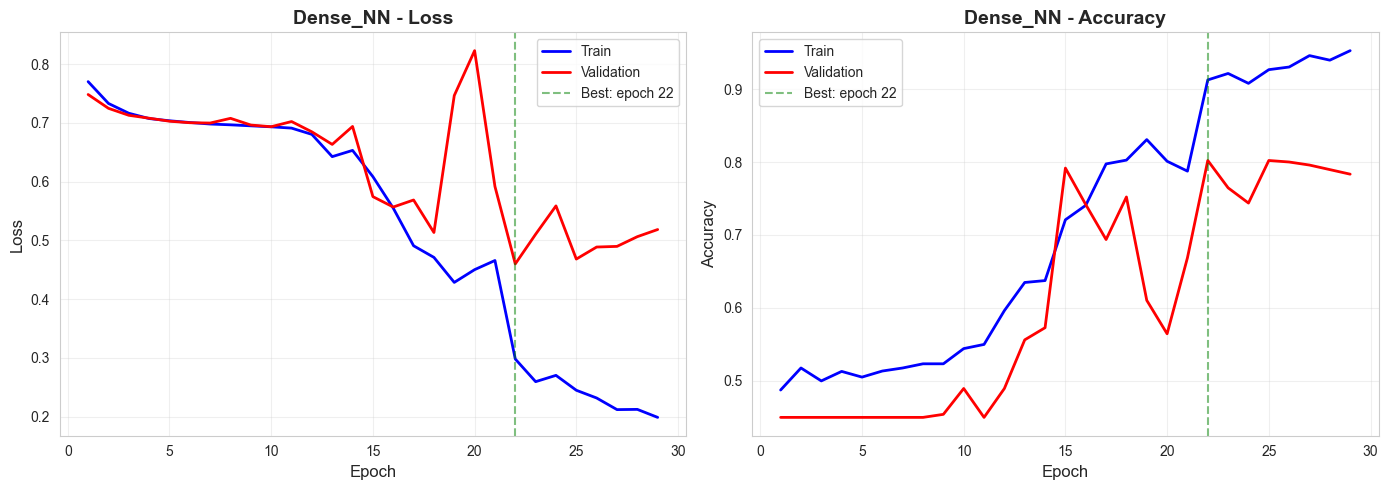


Plotting Vanilla_RNN...
Training history plot saved to: ../outputs/figures/Vanilla_RNN_training_history.png


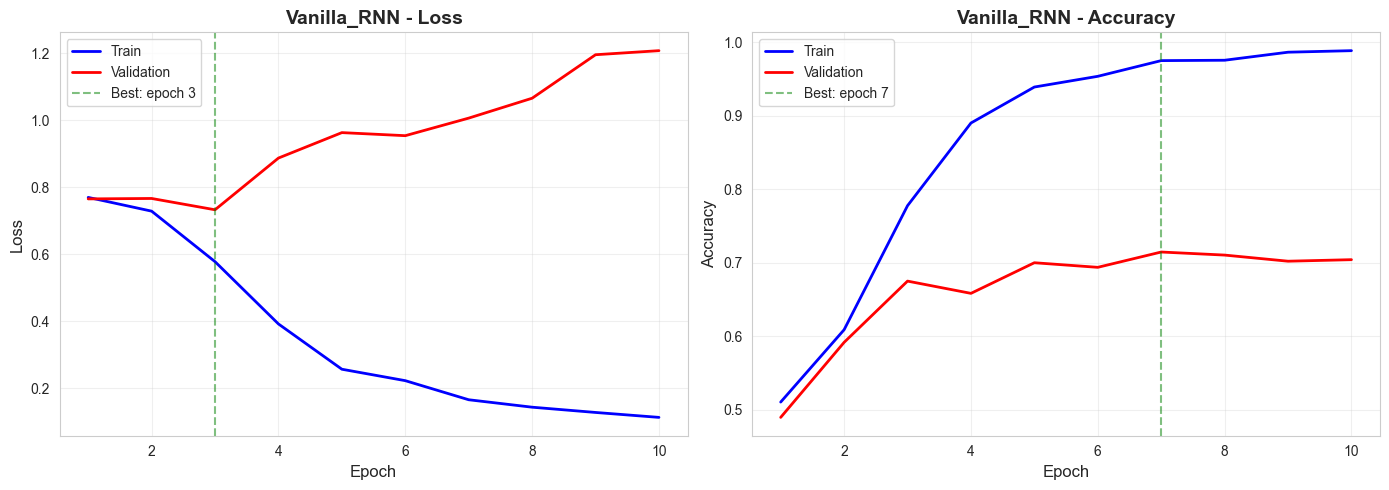


Plotting LSTM...
Training history plot saved to: ../outputs/figures/LSTM_training_history.png


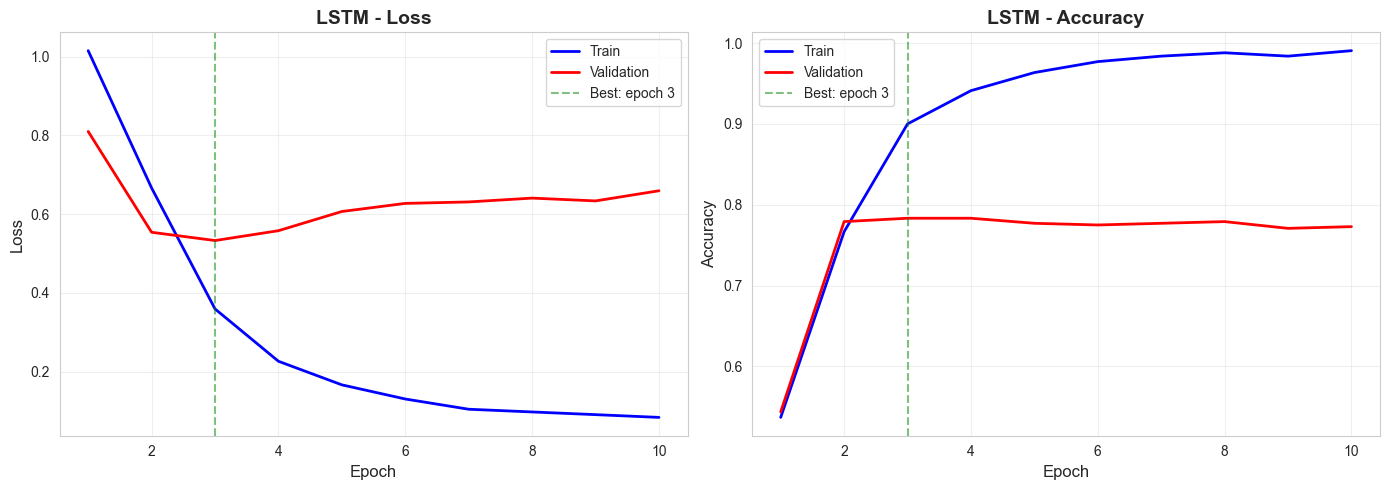


Creating comparison plots...
Training comparison saved to: ../outputs/figures/training_accuracy_comparison.png


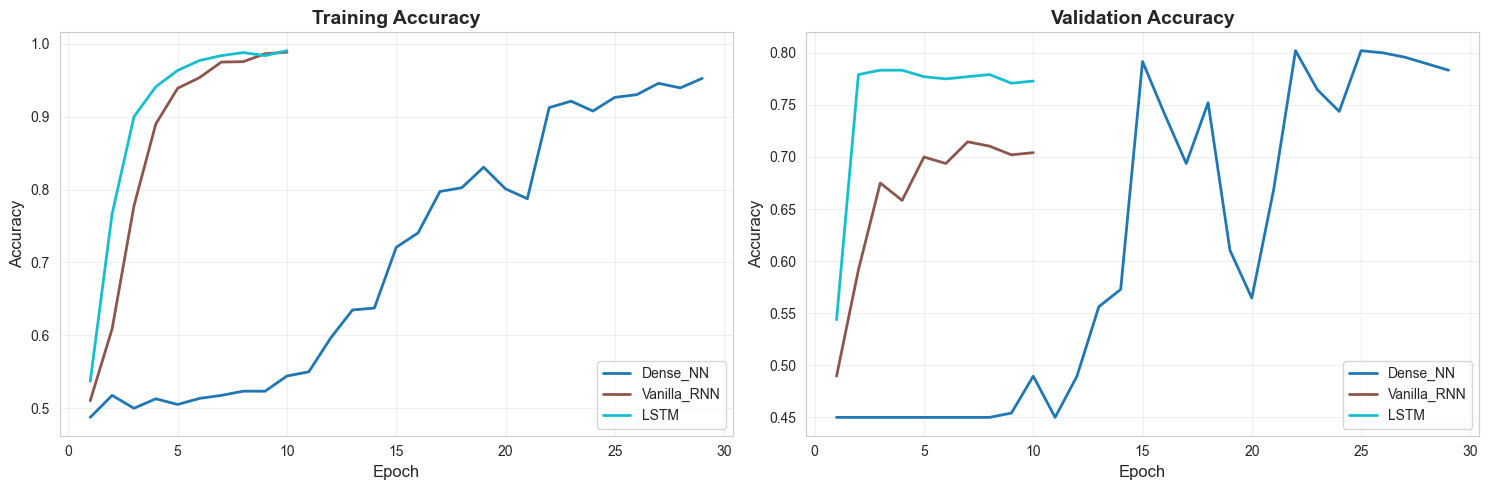

Training comparison saved to: ../outputs/figures/training_loss_comparison.png


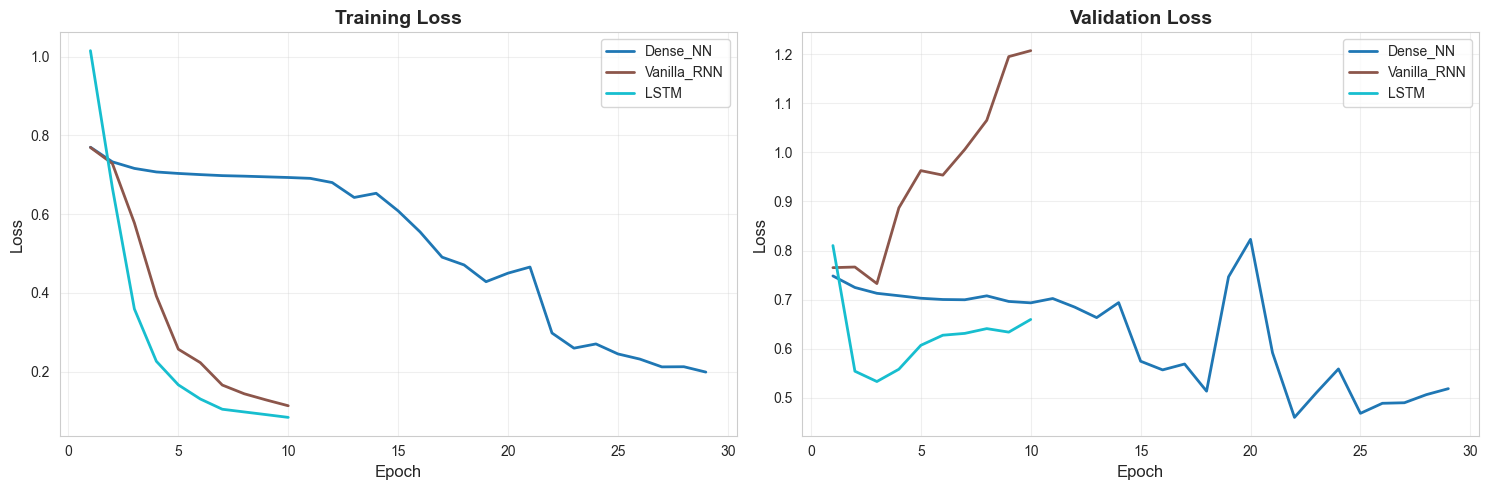

In [9]:
print("VISUALIZING TRAINING HISTORIES")

for model_name, results in train_results.items():
    print(f"\nPlotting {model_name}...")
    plot_training_history(
        results['history'],
        model_name,
        metrics=['loss', 'accuracy'],
        save_path=f'../outputs/figures/{model_name}_training_history.png'
    )

print("\nCreating comparison plots...")
histories = {name: result['history'] for name, result in train_results.items()}

plot_training_comparison(
    histories,
    metric='accuracy',
    save_path='../outputs/figures/training_accuracy_comparison.png'
)

plot_training_comparison(
    histories,
    metric='loss',
    save_path='../outputs/figures/training_loss_comparison.png'
)


## 7. Load Best Models and Evaluate

In [10]:
print("LOADING BEST MODELS FROM CHECKPOINTS")

checkpoint_paths = {
    'Dense_NN': '../outputs/saved_models/Dense_NN_best.keras',
    'Vanilla_RNN': '../outputs/saved_models/Vanilla_RNN_best.keras',
    'LSTM': '../outputs/saved_models/LSTM_best.keras'
}

print("\nVerifying saved checkpoints:")
for name, path in checkpoint_paths.items():
    exists = os.path.exists(path)
    status = " EXISTS" if exists else " NOT FOUND"
    print(f"  {name:15s}: {status}")
    if not exists:
        print(f"    WARNING: {path} not found!")

trained_models = {}
print("\nLoading best weights from checkpoints...")

for name, path in checkpoint_paths.items():
    try:
        trained_models[name] = load_saved_model(path)
        print(f"  {name} loaded successfully")
    except Exception as e:
        print(f"  Error loading {name}: {e}")
        trained_models[name] = train_results[name]['model'].model
        print(f"    Using model from training results instead")



LOADING BEST MODELS FROM CHECKPOINTS

Verifying saved checkpoints:
  Dense_NN       :  EXISTS
  Vanilla_RNN    :  EXISTS
  LSTM           :  EXISTS

Loading best weights from checkpoints...
Model loaded from: ../outputs/saved_models/Dense_NN_best.keras
  Dense_NN loaded successfully
Model loaded from: ../outputs/saved_models/Vanilla_RNN_best.keras
  Vanilla_RNN loaded successfully
Model loaded from: ../outputs/saved_models/LSTM_best.keras
  LSTM loaded successfully


## 8. Evaluate All Models on Test Set


In [11]:

print("EVALUATING MODELS ON TEST SET")

eval_results = evaluate_all_models(trained_models, X_test, y_test)


EVALUATING MODELS ON TEST SET
EVALUATING ALL MODELS

>>> Evaluating Dense_NN...
  Accuracy: 0.8033 | F1: 0.8145 | Kappa: 0.6067

>>> Evaluating Vanilla_RNN...
  Accuracy: 0.7167 | F1: 0.7195 | Kappa: 0.4333

>>> Evaluating LSTM...
  Accuracy: 0.7950 | F1: 0.7987 | Kappa: 0.5900


## 9. Detailed Classification Reports


In [12]:
print("DETAILED CLASSIFICATION REPORTS")

for model_name, results in eval_results.items():
    print(f"{model_name}")
    print(results['classification_report'])


DETAILED CLASSIFICATION REPORTS
Dense_NN
              precision    recall  f1-score   support

    Negative     0.8447    0.7433    0.7908       300
    Positive     0.7708    0.8633    0.8145       300

    accuracy                         0.8033       600
   macro avg     0.8078    0.8033    0.8026       600
weighted avg     0.8078    0.8033    0.8026       600

Vanilla_RNN
              precision    recall  f1-score   support

    Negative     0.7211    0.7067    0.7138       300
    Positive     0.7124    0.7267    0.7195       300

    accuracy                         0.7167       600
   macro avg     0.7168    0.7167    0.7166       600
weighted avg     0.7168    0.7167    0.7166       600

LSTM
              precision    recall  f1-score   support

    Negative     0.8062    0.7767    0.7912       300
    Positive     0.7846    0.8133    0.7987       300

    accuracy                         0.7950       600
   macro avg     0.7954    0.7950    0.7949       600
weighted avg    

## 10. Compare All Models



In [13]:
comparison_df = compare_models(
    eval_results,
    save_path='../outputs/metrics/neural_models_comparison.csv'
)

print_comparison_table(comparison_df)

best_model_name, best_f1 = get_best_model(eval_results, metric='f1_score')
print(f"\n Best Neural Network Model: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")

if baseline_f1 > 0:
    improvement = ((best_f1 - baseline_f1) / baseline_f1) * 100
    print(f"\n Improvement over baseline:")
    print(f"   Baseline F1: {baseline_f1:.4f}")
    print(f"   Best NN F1:  {best_f1:.4f}")
    print(f"   Improvement: +{improvement:.2f}%")
    
    if improvement > 15:
        print("    Target achieved! (>15% improvement)")
    else:
        print("   Target not reached (aimed for >15% improvement)")



Comparison saved to: ../outputs/metrics/neural_models_comparison.csv
MODEL COMPARISON
      Model  accuracy  precision   recall  f1_score  cohen_kappa
   Dense_NN  0.803333   0.770833 0.863333  0.814465     0.606667
       LSTM  0.795000   0.784566 0.813333  0.798691     0.590000
Vanilla_RNN  0.716667   0.712418 0.726667  0.719472     0.433333

 Best Neural Network Model: Dense_NN
   F1-Score: 0.8145

 Improvement over baseline:
   Baseline F1: 0.6667
   Best NN F1:  0.8145
   Improvement: +22.17%
    Target achieved! (>15% improvement)


## 11. Visualize Model Comparison


CREATING COMPARISON VISUALIZATIONS
Metrics comparison saved to: ../outputs/figures/neural_models_metrics_comparison.png


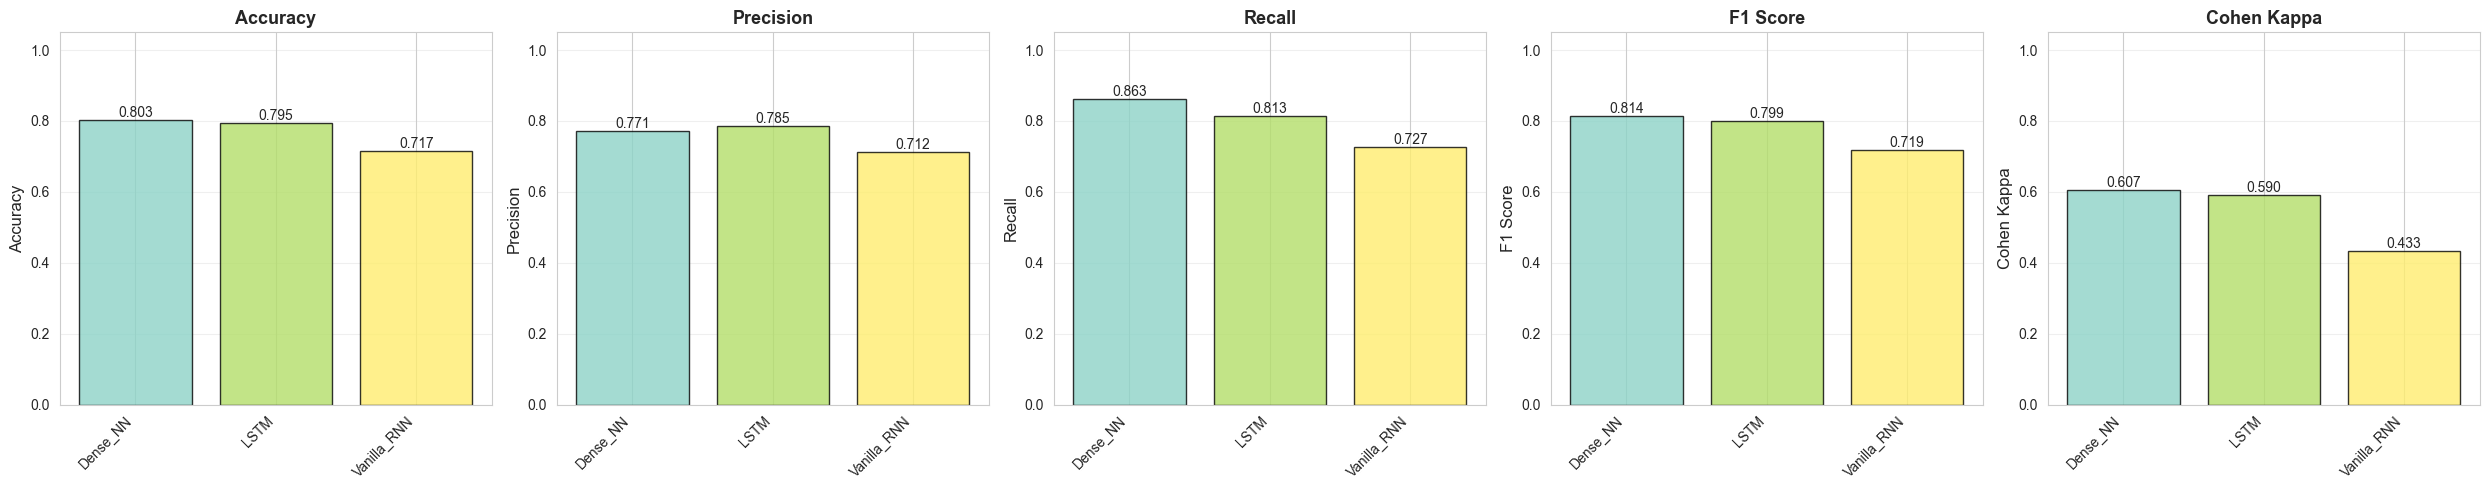


 Comparison visualizations created


In [14]:
print("CREATING COMPARISON VISUALIZATIONS")

# Metrics comparison
plot_metrics_comparison(
    comparison_df,
    save_path='../outputs/figures/neural_models_metrics_comparison.png'
)


print("\n Comparison visualizations created")


## 12. Confusion Matrices

CREATING CONFUSION MATRICES

Plotting confusion matrix for Dense_NN...
Confusion matrix saved to: ../outputs/figures/Dense_NN_confusion_matrix.png


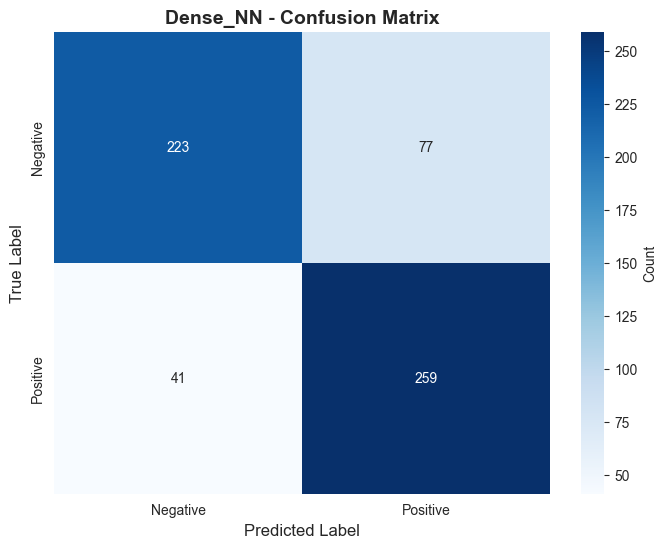


Plotting confusion matrix for Vanilla_RNN...
Confusion matrix saved to: ../outputs/figures/Vanilla_RNN_confusion_matrix.png


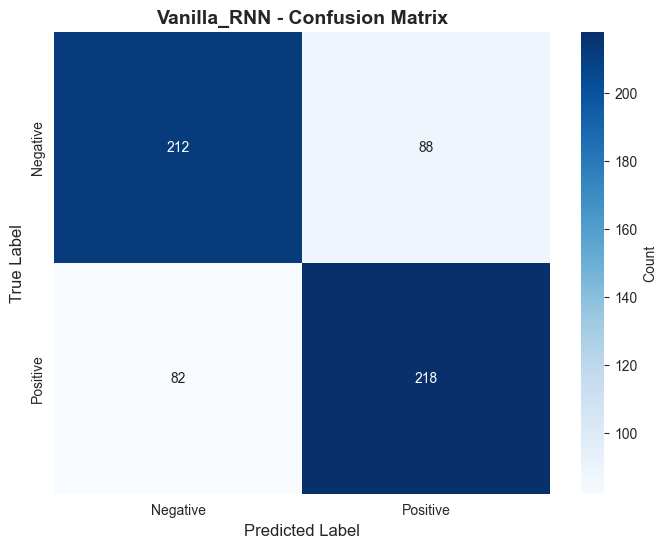


Plotting confusion matrix for LSTM...
Confusion matrix saved to: ../outputs/figures/LSTM_confusion_matrix.png


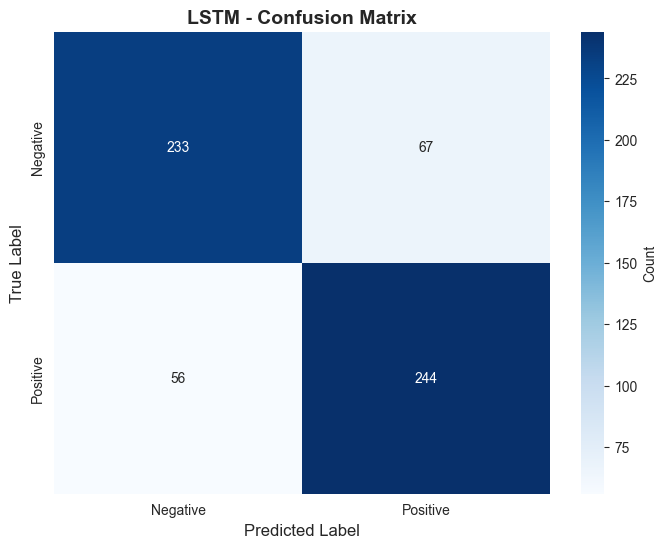


 All confusion matrices created


In [15]:
print("CREATING CONFUSION MATRICES")

for model_name, results in eval_results.items():
    print(f"\nPlotting confusion matrix for {model_name}...")
    plot_confusion_matrix(
        y_test,
        results['y_pred'],
        model_name,
        save_path=f'../outputs/figures/{model_name}_confusion_matrix.png'
    )

print("\n All confusion matrices created")


## 13. Error Analysis

In [16]:
print("ERROR ANALYSIS")

for model_name, results in eval_results.items():
    print(f"{model_name} - Error Analysis")
    
    error_analysis = calculate_error_analysis(
        y_test,
        results['y_pred'],
        results['y_pred_proba']
    )
    
    print_error_analysis(error_analysis)


ERROR ANALYSIS
Dense_NN - Error Analysis
ERROR ANALYSIS
Total Errors:        118
Error Rate:          19.67%
False Positives:     77
False Negatives:     41
Avg Error Confidence: 0.2094
Vanilla_RNN - Error Analysis
ERROR ANALYSIS
Total Errors:        170
Error Rate:          28.33%
False Positives:     88
False Negatives:     82
Avg Error Confidence: 0.2680
LSTM - Error Analysis
ERROR ANALYSIS
Total Errors:        123
Error Rate:          20.50%
False Positives:     67
False Negatives:     56
Avg Error Confidence: 0.2166


## 14. Prediction Distribution Analysis

In [17]:
print("PREDICTION DISTRIBUTION ANALYSIS")

print(f"\n{'Real Distribution in Test Set':^60}")
neg_count = np.sum(y_test == 0)
pos_count = np.sum(y_test == 1)
print(f"Negative (0): {neg_count:>5d} ({100*neg_count/len(y_test):>5.2f}%)")
print(f"Positive (1): {pos_count:>5d} ({100*pos_count/len(y_test):>5.2f}%)")

for model_name, results in eval_results.items():
    y_pred = results['y_pred']
    
    print(f"\n{model_name + ' Predictions':^60}")
    pred_neg = np.sum(y_pred == 0)
    pred_pos = np.sum(y_pred == 1)
    print(f"Negative (0): {pred_neg:>5d} ({100*pred_neg/len(y_pred):>5.2f}%)")
    print(f"Positive (1): {pred_pos:>5d} ({100*pred_pos/len(y_pred):>5.2f}%)")
    
    accuracy = results['metrics']['accuracy']
    print(f"Accuracy:     {accuracy:.4f}")


PREDICTION DISTRIBUTION ANALYSIS

               Real Distribution in Test Set                
Negative (0):   300 (50.00%)
Positive (1):   300 (50.00%)

                    Dense_NN Predictions                    
Negative (0):   264 (44.00%)
Positive (1):   336 (56.00%)
Accuracy:     0.8033

                  Vanilla_RNN Predictions                   
Negative (0):   294 (49.00%)
Positive (1):   306 (51.00%)
Accuracy:     0.7167

                      LSTM Predictions                      
Negative (0):   289 (48.17%)
Positive (1):   311 (51.83%)
Accuracy:     0.7950


## 15. Save All Results

SAVING ALL RESULTS
Results saved for Dense_NN
Results saved for Vanilla_RNN
Results saved for LSTM

All results saved to: ../outputs/metrics

Generating visualizations for report...
  - Metrics comparison...
Metrics comparison saved to: ../outputs/figures/metrics_comparison.png


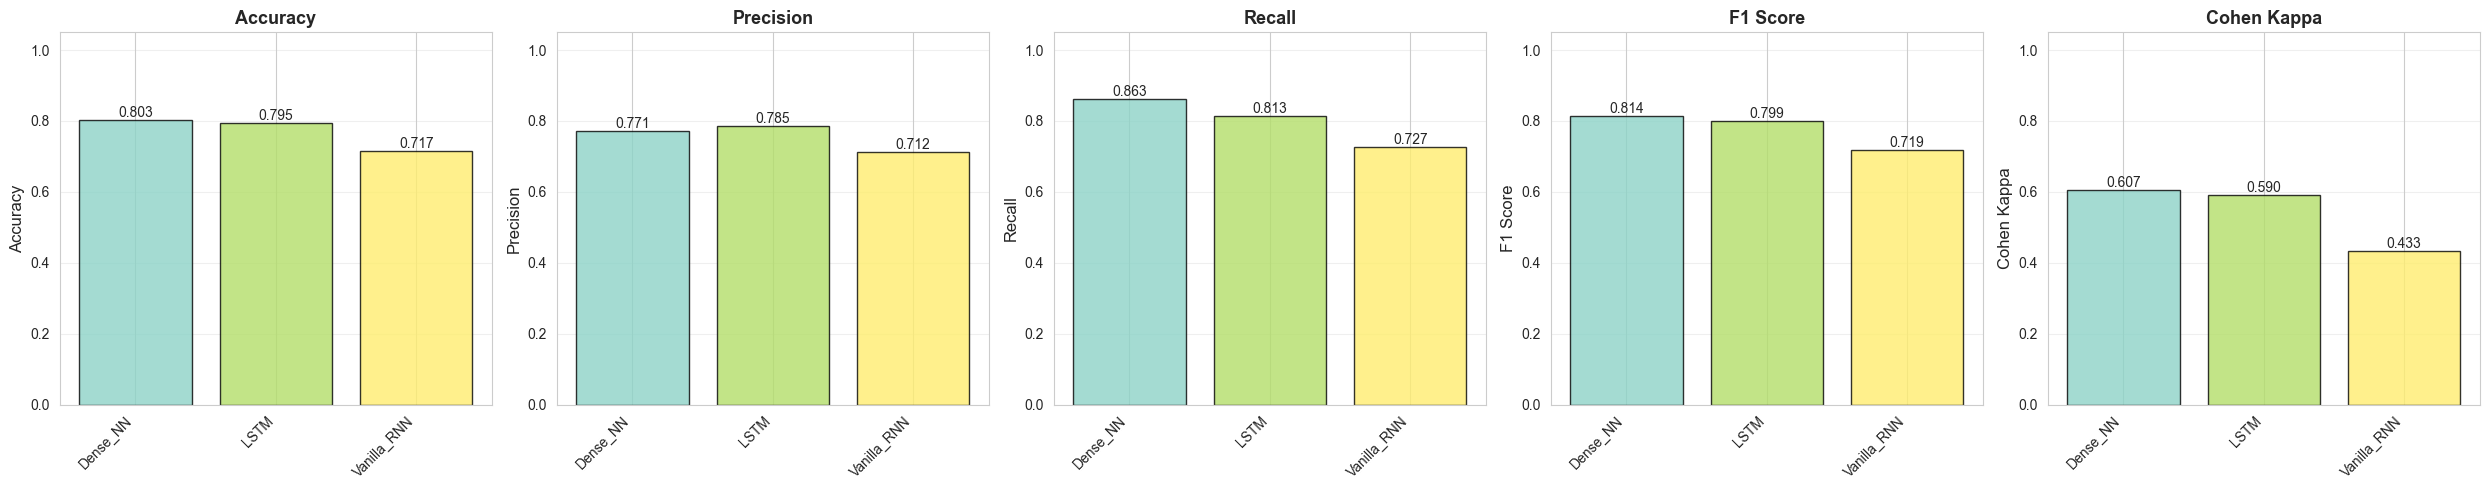

  - Confusion matrices...
Confusion matrix saved to: ../outputs/figures/Dense_NN_confusion_matrix.png


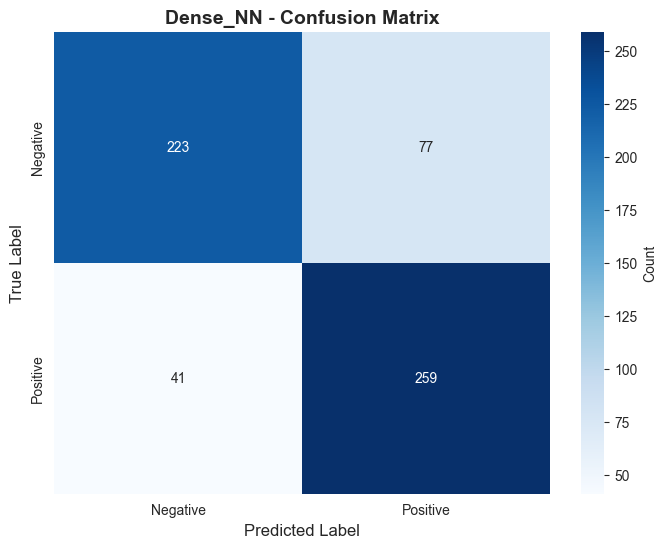

Confusion matrix saved to: ../outputs/figures/Vanilla_RNN_confusion_matrix.png


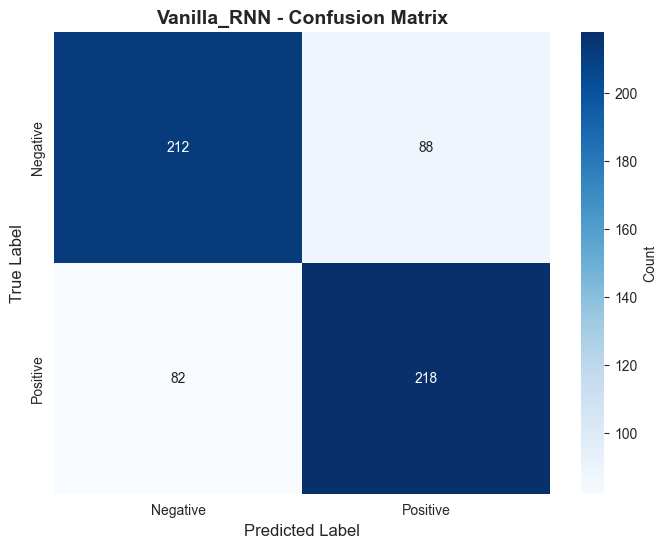

Confusion matrix saved to: ../outputs/figures/LSTM_confusion_matrix.png


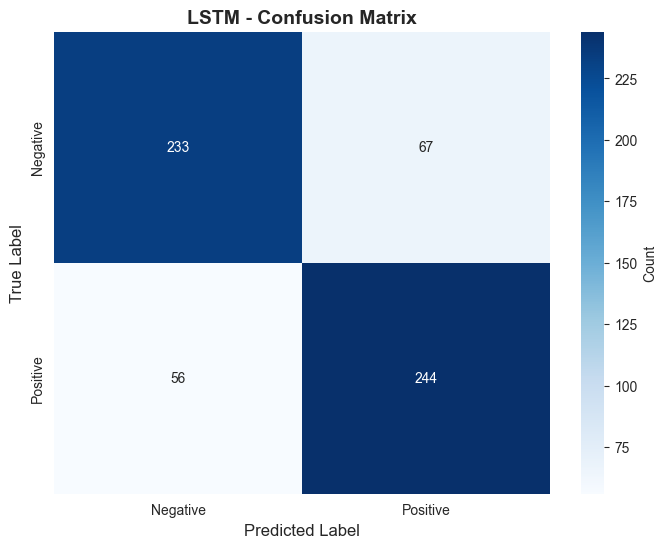


 All visualizations saved to: ../outputs/figures

 All results saved successfully


In [18]:
print("SAVING ALL RESULTS")

save_evaluation_results(eval_results, output_dir='../outputs/metrics')

create_full_report(
    eval_results,
    comparison_df,
    y_test,
    output_dir='../outputs/figures'
)

combined_results = {
    'training_results': {
        model_name: {
            'training_time': results['training_time'],
            'final_train_loss': results['history'].history['loss'][-1],
            'final_train_accuracy': results['history'].history['accuracy'][-1],
            'final_val_loss': results['history'].history['val_loss'][-1],
            'final_val_accuracy': results['history'].history['val_accuracy'][-1],
            'best_epoch': int(np.argmax(results['history'].history['val_accuracy']) + 1)
        }
        for model_name, results in train_results.items()
    },
    'test_results': {
        model_name: {
            k: float(v) if isinstance(v, (np.floating, float)) else v
            for k, v in results['metrics'].items()
        }
        for model_name, results in eval_results.items()
    },
    'best_model': best_model_name,
    'best_f1_score': float(best_f1),
    'baseline_f1_score': float(baseline_f1) if baseline_f1 > 0 else None,
    'improvement_over_baseline': float(((best_f1 - baseline_f1) / baseline_f1) * 100) if baseline_f1 > 0 else None
}

with open('../outputs/metrics/combined_results.json', 'w') as f:
    json.dump(combined_results, f, indent=2)

print("\n All results saved successfully")

## 16. Final Summary and Conclusions

In [20]:
print("FINAL SUMMARY")

print("\n Model Performance Summary:")
print(f"{'Model':<20s} {'Accuracy':<12s} {'Precision':<12s} {'Recall':<12s} {'F1-Score':<12s} {'Time (s)':<10s}")

for model_name in ['Dense_NN', 'Vanilla_RNN', 'LSTM']:
    metrics = eval_results[model_name]['metrics']
    train_time = train_results[model_name]['training_time']
    
    print(f"{model_name:<20s} "
          f"{metrics['accuracy']:<12.4f} "
          f"{metrics['precision']:<12.4f} "
          f"{metrics['recall']:<12.4f} "
          f"{metrics['f1_score']:<12.4f} "
          f"{train_time:<10.2f}")


# Key insights
print("\n Key Insights:")

# Find best and worst
best_acc_model = max(eval_results.items(), key=lambda x: x[1]['metrics']['accuracy'])[0]
best_f1_model = max(eval_results.items(), key=lambda x: x[1]['metrics']['f1_score'])[0]
fastest_model = min(train_results.items(), key=lambda x: x[1]['training_time'])[0]

print(f"1. Best Accuracy:  {best_acc_model} ({eval_results[best_acc_model]['metrics']['accuracy']:.4f})")
print(f"2. Best F1-Score:  {best_f1_model} ({eval_results[best_f1_model]['metrics']['f1_score']:.4f})")
print(f"3. Fastest Training: {fastest_model} ({train_results[fastest_model]['training_time']:.2f}s)")

if baseline_f1 > 0:
    print(f"\n4. All models exceeded baseline F1 of {baseline_f1:.4f}:")
    for model_name, results in eval_results.items():
        f1 = results['metrics']['f1_score']
        improvement = ((f1 - baseline_f1) / baseline_f1) * 100
        status = "✓" if f1 > baseline_f1 else "✗"
        print(f"   {status} {model_name}: {f1:.4f} (+{improvement:.2f}%)")

print("EVALUATION COMPLETE!")


FINAL SUMMARY

 Model Performance Summary:
Model                Accuracy     Precision    Recall       F1-Score     Time (s)  
Dense_NN             0.8033       0.7708       0.8633       0.8145       9.04      
Vanilla_RNN          0.7167       0.7124       0.7267       0.7195       7.40      
LSTM                 0.7950       0.7846       0.8133       0.7987       73.02     

 Key Insights:
1. Best Accuracy:  Dense_NN (0.8033)
2. Best F1-Score:  Dense_NN (0.8145)
3. Fastest Training: Vanilla_RNN (7.40s)

4. All models exceeded baseline F1 of 0.6667:
   ✓ Dense_NN: 0.8145 (+22.17%)
   ✓ Vanilla_RNN: 0.7195 (+7.92%)
   ✓ LSTM: 0.7987 (+19.80%)
EVALUATION COMPLETE!
